In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [29]:
client = bnb_client(tld='US')

def get_data(symbol,freq,start_ts = '2025-01-01',end_ts='2025-07-15'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data

In [30]:
universe = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 
            'XRPUSDT',  'DOGEUSDT']
freq = '1d'


px = {}
for x in universe:
    data = get_data(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_8848/67391828.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_8848/67391828.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_8848/67391828.py:12: Depre

In [27]:
ret

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT,XRPUSDT,DOGEUSDT
2025-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-02,0.028720,0.068423,0.019323,0.035598,0.076356,0.028321,0.073127
2025-07-03,0.008518,0.008620,0.007240,0.003352,0.025703,0.011196,0.045923
2025-07-04,-0.015337,-0.030154,-0.015189,-0.033866,-0.041430,-0.016962,-0.074783
2025-07-05,0.002896,0.002509,0.004039,0.000203,0.005228,0.000315,0.006429
2025-07-06,0.008834,0.020651,0.010927,0.029149,0.013350,0.023779,0.045814
2025-07-07,-0.009159,-0.009461,-0.004643,-0.018706,-0.008212,0.000484,-0.022980
2025-07-08,0.007138,0.027926,-0.000666,0.018996,0.013628,0.015697,0.018816
2025-07-09,0.022816,0.057312,0.012579,0.034319,0.059564,0.040693,0.051549
2025-07-10,0.040931,0.067187,0.029575,0.044899,0.088339,0.061314,0.084315


/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_8848/1015445718.py:16: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)


,1,2,3,4,5,6
2025-12-31,1.379625,3.340401,3.722954,2.334608,4.261345,-0.445972


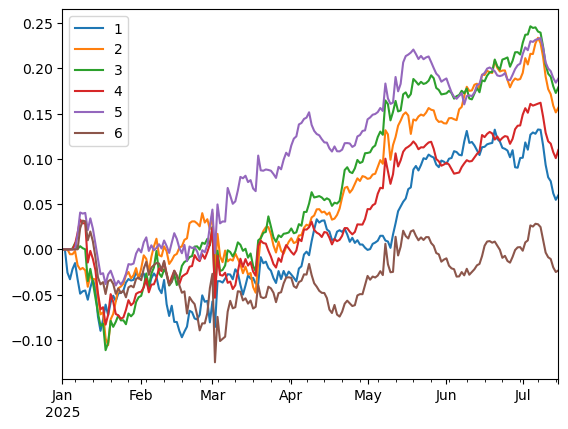

In [31]:
strat_returns = {}

l = range(1,7)

for x in l:
    past = ret.rolling(x).mean().rank()
        
    demeaned = past.subtract(past.mean(axis=1), axis=0)
    weights = demeaned.divide(demeaned.abs().sum(axis=1), axis=0) * -1
    
    strat_returns[x] = (weights.shift()*ret).sum(1)
    

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)
strat_returns.cumsum().plot()
sr